<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/oal_relaxation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 4.5MB/s 
     |████████████████████████████████| 6.7MB 7.3MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 2.1MB 58.9MB/s 
     |████████████████████████████████| 12.8MB 239kB/s 
     |████████████████████████████████| 110.5MB 59kB/s 
     |████████████████████████████████| 3.8MB 23.0MB/s 
     |████████████████████████████████| 512kB 29.8MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... 

In [2]:
import multiprocessing as mp
import copy
import numpy as np

import ase
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, QuasiNewton

import torch

from amptorch.model import CustomMSELoss
from amptorch.active_learning.atomistic_methods  import MDsimulate, Relaxation
from amptorch.active_learning.oal_calc  import AMPOnlineCalc

import dftbook
dftbook.setup_colab()
from espresso import Espresso
from ase.utils.eos import EquationOfState
from ase.build import bulk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 21.3 seconds


/usr/local/lib/python3.6/dist-packages/ase/utils/eos.py:5: UserWarning: Moved to ase.eos
  warnings.warn('Moved to ase.eos')


In [0]:
def get_structure(base_calc):
    energies = []
    volumes = []
    LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

    for a in LC:
      cu_bulk = bulk('Cu', 'fcc', a=a)

      calc = Espresso(xc='PBE',
                  pw=500,
                  calculation='scf',
                  kpts=[12, 12, 12])

      cu_bulk.set_calculator(calc)

      e = cu_bulk.get_potential_energy()
      energies.append(e)
      volumes.append(cu_bulk.get_volume())


    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    aref=3.6
    vref = bulk('Cu', 'fcc', a=aref).get_volume()

    copper_lattice_constant = (v0/vref)**(1/3)*aref

    slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
    ads = molecule("C")
    add_adsorbate(slab, ads, 2, offset=(1, 1))
    cons = FixAtoms(
      indices=[atom.index for atom in slab if (atom.tag == 3)]
    )
    slab.set_constraint(cons)
    slab.center(vacuum=13.0, axis=2)
    slab.set_pbc(True)
    slab.wrap(pbc=[True] * 3)
    slab.set_calculator(copy.copy(base_calc))
    slab.set_initial_magnetic_moments()

    return slab

In [0]:
  def main():
    base_calc = Espresso(pw=500.0, 
              calculation='scf',
              kpts=(4,4,1),
              xc='PBE')
    
    slab = get_structure(base_calc)

    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

    images = [slab]

    training_params = {
      "uncertain_tol": 0.1,
      "Gs": Gs,
      "morse": True,
      "forcetraining": True,
      "cores": 3,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "filename": "oal_test",
      "verbose": 1
    }

    structure_optim = Relaxation(slab, BFGS, fmax=0.05, steps=50)
    online_calc = AMPOnlineCalc(parent_dataset=images, parent_calc=base_calc, n_ensembles=5, n_cores=2, training_params=training_params)
    structure_optim.run(online_calc, filename='relax_oal')

    # Calculate true relaxation
    true_relax = Relaxation(slab, BFGS)
    true_relax.run(copy.copy(base_calc), 'true_relax')
    parent_calc_traj = true_relax.get_trajectory('true_relax', 0, -1, 1)
    n_parent_calls = online_calc.parent_calls
    final_oal_traj = ase.io.read("./relax_oal.traj", ":")

    # Visualize Results

    # Calculate true relaxation
    parent_calc_traj = true_relax.get_trajectory('true_relax', 0, -1, 1)
    n_parent_calls = online_calc.parent_calls
    final_oal_traj = ase.io.read("./relax_oal.traj", ":")

    #Compute ML predicted energies
    ml_relaxation_energies = [image.get_potential_energy() for image in final_oal_traj]
    #Compute actual (DFT) energies for ML predicted structures
    dft_evaluated_ml_energies = [copy.copy(base_calc).get_potential_energy(image) for image in final_oal_traj]
    #Compute actual energies for EMT relaxation structures
    dft_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
    ml_steps = range(len(final_oal_traj))
    dft_steps = range(len(parent_calc_traj))

    plt.plot(ml_steps, ml_relaxation_energies, '--b', label='OAL_relaxation')
    plt.plot(ml_steps, dft_evaluated_ml_energies, '-g', label='DFT@OAL_relaxation')
    plt.plot(dft_steps, dft_relaxation_energies, '-r', label='DFT_relaxation')
    plt.xlabel("Steps")
    plt.ylabel("Energy, eV")
    plt.title('OAL vs DFT Relaxation')
    plt.legend()
    plt.show()

    def compute_loss(a, b):
      return np.mean(np.sqrt(np.sum((a - b)**2, axis=1)))

    initial_structure = images[0].positions
    print(f'Number of OAL steps: {len(final_oal_traj)}\nTotal # of queries (DFT calls): {n_parent_calls} \n')
    print(f"Final OAL Relaxed Energy: {ml_relaxation_energies[-1]}")
    print(f'DFT evaluation at AL structure: {dft_evaluated_ml_energies[-1]}\n')
    al_relaxed_structure = final_oal_traj[-1].positions

    print(f'Total number of DFT steps: {len(dft_relaxation_energies)}')
    print(f'Final DFT Relaxed Energy: {dft_relaxation_energies[-1]}\n')
    dft_relaxed_structure = parent_calc_traj[-1].positions


    initial_structure_error = compute_loss(initial_structure, dft_relaxed_structure)
    relaxed_structure_error = compute_loss(al_relaxed_structure, dft_relaxed_structure)

    print(f'Initial structure error: {initial_structure_error}')
    print(f'AL relaxed structure error: {relaxed_structure_error}')

      Step     Time          Energy         fmax
BFGS:    0 13:12:33   -66070.351562        2.8550
BFGS:    1 13:12:33   -66070.515625        2.3400
BFGS:    2 13:12:33   -66070.617188        1.6712
BFGS:    3 13:12:34   -66070.664062        0.9350
BFGS:    4 13:12:34   -66070.703125        1.4427
BFGS:    5 13:20:27   -66070.851782        0.6579
BFGS:    6 13:20:27   -66070.867188        0.5714
BFGS:    7 13:27:23   -66070.887001        0.9519
BFGS:    8 13:27:24   -66070.898438        1.2235
BFGS:    9 13:34:06   -66070.923742        0.9099
BFGS:   10 13:42:37   -66070.946777        0.7378
BFGS:   11 13:50:43   -66070.961303        0.4781
BFGS:   12 13:50:43   -66070.968750        0.1835
BFGS:   13 13:50:43   -66070.968750        0.1295
BFGS:   14 13:50:43   -66070.968750        0.1247
BFGS:   15 13:50:44   -66070.968750        0.1297
BFGS:   16 13:50:44   -66070.976562        0.1646
BFGS:   17 13:50:44   -66070.968750        0.1859
BFGS:   18 13:50:45   -66070.976562        0.2022
B

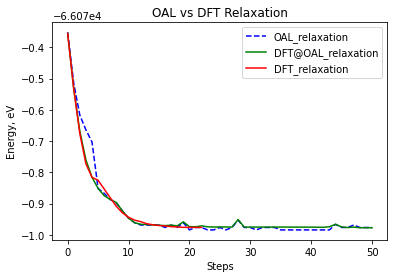

Number of OAL steps: 51
Total # of queries (DFT calls): 6 

Final OAL Relaxed Energy: -66070.9765625
DFT evaluation at AL structure: -66070.97750767077

Total number of DFT steps: 23
Final DFT Relaxed Energy: -66070.97629608383

Initial structure error: 0.0770979164511575
AL relaxed structure error: 0.005536081658527684


In [5]:
if __name__ == "__main__":
  try:
    mp.set_start_method("spawn")
  except:
    if mp.get_start_method() == "spawn":
      pass
    else:
      raise Exception('Wrong mp start method!')
  main()